In [30]:
import tensorflow as tf
keras = tf.keras
import warnings
warnings.filterwarnings("ignore")
import gensim, re
import numpy as np
import pandas as pd
import openpyxl
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.models import load_model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Bidirectional, Dropout
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [31]:
!pip install bltk
!pip install pandas
import pandas as pd
from bltk.langtools import remove_stopwords
import regex as re
from bltk.langtools import Tokenizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df=pd.read_excel('/content/drive/MyDrive/suicide/suicide_data2.xlsx')
main_data = pd.read_excel( "/content/drive/MyDrive/suicide/suicide_data2.xlsx" )
#df=pd.read_excel('/content/drive/MyDrive/suicide/suicide_data.xlsx')
#main_data = pd.read_excel( "/content/drive/MyDrive/suicide/suicide_data.xlsx" )
labels = main_data['label'].tolist()
df.head()

,text,label
0,আমি একদিন নিজেকে মেরে ফেলব এই বিষয়টি আমি নিশ...,1
1,বেচে থাকার কোন কারণ আমি ভাবতে পারি না। জীবনের ...,1
2,আমি কমপক্ষে ১ বছর ধরে সুইসাইড করার কথা ভাবছি। ...,1
3,আমার আর বাঁচার দরকার নেই। আমি ওর সাথে সম্পর্ক...,1
4,আমি এভাবে আর বাঁচব না। আমার হতাশা ও আত্মহত্যার...,1


In [5]:
from bltk.langtools.banglachars import (vowels,
                                        vowel_signs,
                                        consonants,
                                        digits,
                                        operators,
                                        punctuations,
                                        others)
print(f'Vowels: {vowels}')
print(f'Vowel signs: {vowel_signs}')
print(f'Consonants: {consonants}')
print(f'Digits: {digits}')
print(f'Operators: {operators}')
print(f'Punctuation marks: {punctuations}')
print(f'Others: {others}')

Vowels: ['অ', 'আ', 'ই', 'ঈ', 'উ', 'ঊ', 'ঋ', 'ঌ', 'এ', 'ঐ', 'ও', 'ঔ']
Vowel signs: ['া', 'ি', 'ী', 'ু', 'ূ', 'ৃ', 'ৄ', 'ে', 'ৈ', 'ো', 'ৌ']
Consonants: ['ক', 'খ', 'গ', 'ঘ', 'ঙ', 'চ', 'ছ', 'জ', 'ঝ', 'ঞ', 'ট', 'ঠ', 'ড', 'ঢ', 'ণ', 'ত', 'থ', 'দ', 'ধ', 'ন', 'প', 'ফ', 'ব', 'ভ', 'ম', 'য', 'র', 'ল', 'শ', 'ষ', 'স', 'হ', 'ড়', 'ঢ়', 'য়', 'ৎ', 'ং', 'ঃ', 'ঁ']
Digits: ['০', '১', '২', '৩', '৪', '৫', '৬', '৭', '৮', '৯']
Operators: ['=', '+', '-', '*', '/', '%', '<', '>', '×', '÷']
Punctuation marks: ['।', ',', ';', ':', '?', '!', "'", '.', '"', '-', '[', ']', '{', '}', '(', ')', '–', '—', '―', '~']
Others: ['৳', '৺', '্', 'ঀ', 'ঽ', '#', '$']


In [6]:
def punc(tokens):
  valid_tokens=[]
  for token in tokens:
    if token not in punctuations:
      valid_tokens.append(token)
  tokens=valid_tokens
  return tokens

In [25]:
new_list=[]
for c in vowels:
  new_list.append(c)
for c in vowel_signs:
  new_list.append(c)
for c in consonants:
  new_list.append(c)
new_list.append('্')
new_list.append('য়')
def tokenize(text):
    token=[]
    text=str(text)
    #print(text)
    new_text=""
    for c in text:
      if c in new_list:
        new_text=new_text+c
      else:
        new_text=new_text+' '
    tokenizer = Tokenizer()
    text=new_text
    words=tokenizer.word_tokenizer(text)
    for word in words:
      if word not in token:
        siz=0
        for c in word:
          siz=siz+1
        if siz>0:
          token.append(word)
    return token

In [26]:
def stp_remove(tkn):
  words=remove_stopwords(tkn, level='soft')
  return words

In [27]:
df2=pd.read_excel('/content/drive/MyDrive/suicide/rules.xlsx')
pd.set_option('display.max_rows', None)
df2.head()
#print(df2)

,rule
0,ই
1,ও
2,তো
3,কে
4,তে


In [28]:
def stemming(text, pattern):
    mi=min(len(text),len(pattern))
    cnt=0
    len_text=len(text)
    len_pattern=len(pattern)
    cnt=-2
    for i in range(mi):
      if(text[len_text-(i+1)]!=pattern[len_pattern-(i+1)]):
        break
      cnt=i
    len_text=len_text-cnt
    txt=text
    if cnt+1==mi:
      txt = text[0:len_text-1]
    return txt

In [32]:
posts= list()
for text in df["text"]:
    text=str(text)
    text=tokenize(text)
    text=punc(text)
    text=stp_remove(text)
    new_tokens=[]
    for txt in text:
       temp=txt
       for rule in df2["rule"]:
           temp=stemming(txt,rule)
           if temp!=txt:
               break
       if len(temp)>0:
          new_tokens.append(temp)
    posts.append(new_tokens)
cleaned_data=posts

In [33]:
from tensorflow.keras.preprocessing.text import Tokenizer
features = 100
tokenizer = Tokenizer(num_words=features)

In [34]:

tokenizer.fit_on_texts(cleaned_data)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(cleaned_data)

maxlen=10
padType='post'

X = pad_sequences(sequences, maxlen=maxlen, padding="post", truncating="post")
y = np.asarray(pd.get_dummies(labels))

In [35]:
len(X), len(y)

(1402, 1402)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True)

In [37]:


def get_model(num_of_layer):
    model = Sequential()
    model.add(Embedding(4000, features, input_length = X.shape[1]))
    
    for i in range(num_of_layer):
        if i>0:
            model.add(LSTM(features, return_sequences=True))
        
    model.add(LSTM(features, return_sequences=False))
    model.add(Dense(10, activation="relu"))
    model.add(Dense(y.shape[1], activation="softmax"))

    opt = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model;

In [38]:
def run_model(model, batch, epochs):
    history = model.fit(X_train, y_train, batch, epochs, validation_data=(X_test, y_test), verbose=1)
    return history

In [39]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()


Epoch 1/10
36/36 [==============================] - 6s 65ms/step - loss: 0.6922 - accuracy: 0.5227 - val_loss: 0.6921 - val_accuracy: 0.5018
Epoch 2/10
36/36 [==============================] - 1s 37ms/step - loss: 0.6883 - accuracy: 0.5388 - val_loss: 0.6897 - val_accuracy: 0.5089
Epoch 3/10
36/36 [==============================] - 2s 44ms/step - loss: 0.6842 - accuracy: 0.5709 - val_loss: 0.6812 - val_accuracy: 0.5552
Epoch 4/10
36/36 [==============================] - 1s 36ms/step - loss: 0.6688 - accuracy: 0.6512 - val_loss: 0.6463 - val_accuracy: 0.7438
Epoch 5/10
36/36 [==============================] - 2s 42ms/step - loss: 0.6164 - accuracy: 0.7654 - val_loss: 0.5372 - val_accuracy: 0.8292
Epoch 6/10
36/36 [==============================] - 2s 43ms/step - loss: 0.4846 - accuracy: 0.8475 - val_loss: 0.3660 - val_accuracy: 0.8826
Epoch 7/10
36/36 [==============================] - 2s 49ms/step - loss: 0.3452 - accuracy: 0.8653 - val_loss: 0.3041 - val_accuracy: 0.8826
Epoch 8/10
36

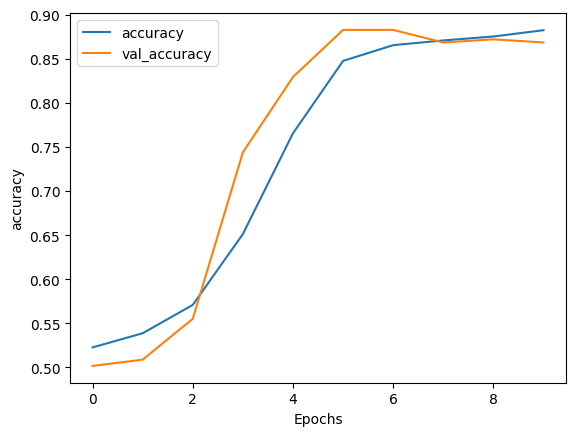

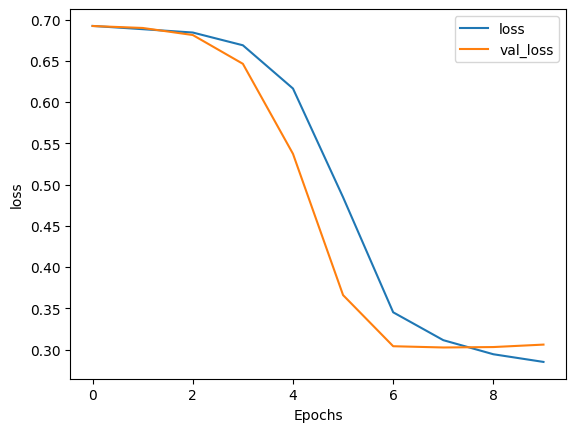

9/9 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       128
           1       0.90      0.86      0.88       153

    accuracy                           0.87       281
   macro avg       0.87      0.87      0.87       281
weighted avg       0.87      0.87      0.87       281

Epoch 1/10
36/36 [==============================] - 10s 80ms/step - loss: 0.6908 - accuracy: 0.5201 - val_loss: 0.6906 - val_accuracy: 0.4804
Epoch 2/10
36/36 [==============================] - 2s 47ms/step - loss: 0.6844 - accuracy: 0.5531 - val_loss: 0.6810 - val_accuracy: 0.5302
Epoch 3/10
36/36 [==============================] - 2s 44ms/step - loss: 0.6632 - accuracy: 0.6004 - val_loss: 0.6423 - val_accuracy: 0.6335
Epoch 4/10
36/36 [==============================] - 2s 52ms/step - loss: 0.5960 - accuracy: 0.7342 - val_loss: 0.5410 - val_accuracy: 0.8185
Epoch 5/10
36/36 [==============================] - 3s 74

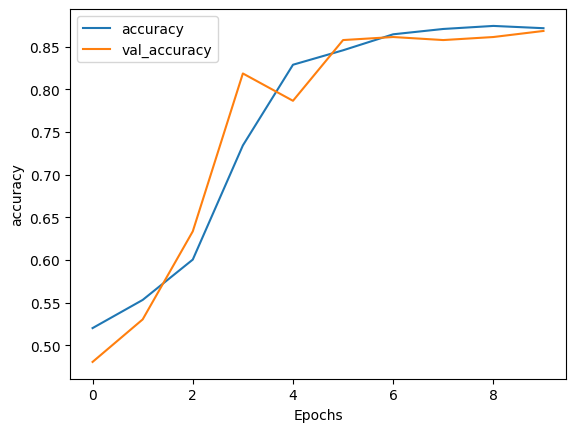

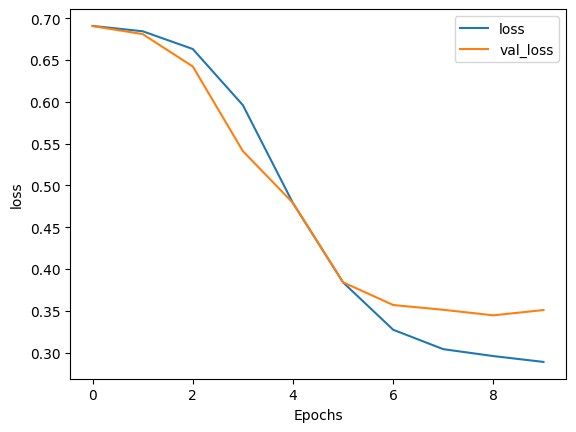

9/9 [==============================] - 1s 12ms/step
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       128
           1       0.91      0.84      0.87       153

    accuracy                           0.87       281
   macro avg       0.87      0.87      0.87       281
weighted avg       0.87      0.87      0.87       281

Epoch 1/10
36/36 [==============================] - 15s 131ms/step - loss: 0.6931 - accuracy: 0.5058 - val_loss: 0.6925 - val_accuracy: 0.5445
Epoch 2/10
36/36 [==============================] - 4s 113ms/step - loss: 0.6920 - accuracy: 0.6280 - val_loss: 0.6871 - val_accuracy: 0.6192
Epoch 3/10
36/36 [==============================] - 3s 69ms/step - loss: 0.6695 - accuracy: 0.5629 - val_loss: 0.5775 - val_accuracy: 0.8399
Epoch 4/10
36/36 [==============================] - 2s 68ms/step - loss: 0.4731 - accuracy: 0.8260 - val_loss: 0.3348 - val_accuracy: 0.8577
Epoch 5/10
36/36 [==============================] - 2s

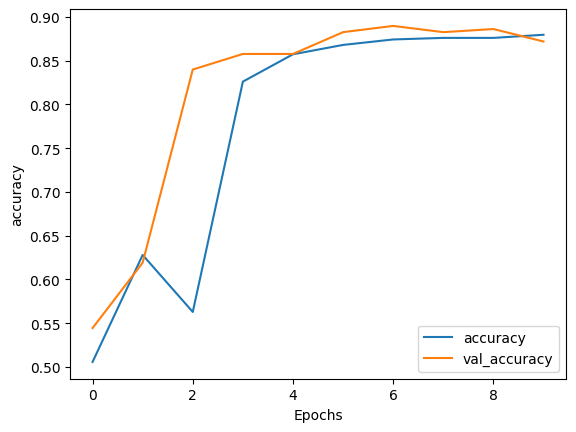

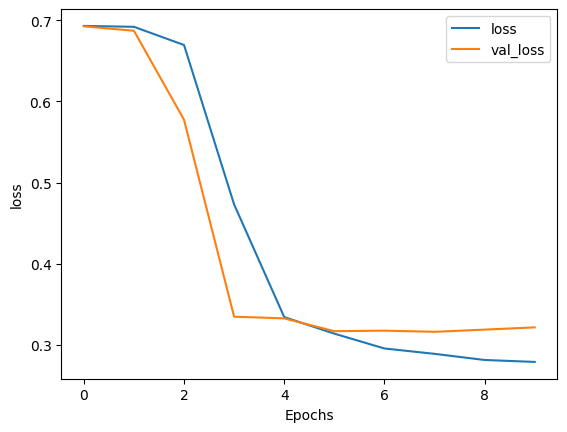

9/9 [==============================] - 3s 28ms/step
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       128
           1       0.91      0.85      0.88       153

    accuracy                           0.87       281
   macro avg       0.87      0.87      0.87       281
weighted avg       0.87      0.87      0.87       281

Epoch 1/20
36/36 [==============================] - 5s 51ms/step - loss: 0.6929 - accuracy: 0.5317 - val_loss: 0.6919 - val_accuracy: 0.6157
Epoch 2/20
36/36 [==============================] - 1s 22ms/step - loss: 0.6908 - accuracy: 0.6137 - val_loss: 0.6879 - val_accuracy: 0.6904
Epoch 3/20
36/36 [==============================] - 1s 22ms/step - loss: 0.6864 - accuracy: 0.6690 - val_loss: 0.6793 - val_accuracy: 0.7509
Epoch 4/20
36/36 [==============================] - 1s 34ms/step - loss: 0.6756 - accuracy: 0.7083 - val_loss: 0.6552 - val_accuracy: 0.7295
Epoch 5/20
36/36 [==============================] - 1s 29

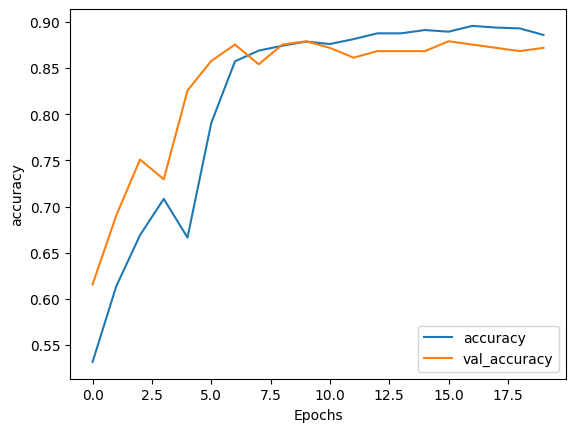

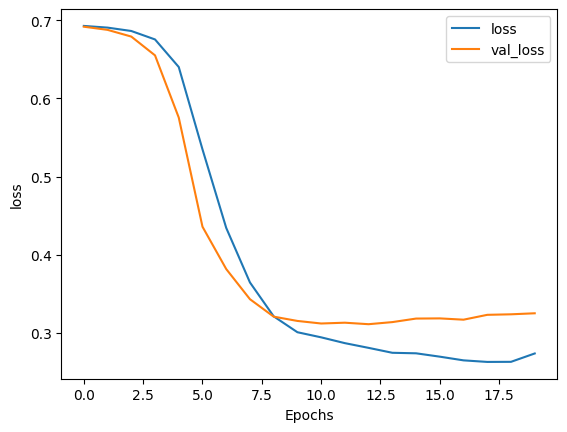

9/9 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       128
           1       0.91      0.84      0.88       153

    accuracy                           0.87       281
   macro avg       0.87      0.87      0.87       281
weighted avg       0.88      0.87      0.87       281

Epoch 1/20
36/36 [==============================] - 12s 154ms/step - loss: 0.6922 - accuracy: 0.5040 - val_loss: 0.6913 - val_accuracy: 0.4733
Epoch 2/20
36/36 [==============================] - 2s 52ms/step - loss: 0.6875 - accuracy: 0.5317 - val_loss: 0.6840 - val_accuracy: 0.5587
Epoch 3/20
36/36 [==============================] - 2s 52ms/step - loss: 0.6716 - accuracy: 0.6209 - val_loss: 0.6463 - val_accuracy: 0.6904
Epoch 4/20
36/36 [==============================] - 3s 73ms/step - loss: 0.5888 - accuracy: 0.7493 - val_loss: 0.4924 - val_accuracy: 0.8327
Epoch 5/20
36/36 [==============================] - 2s 6

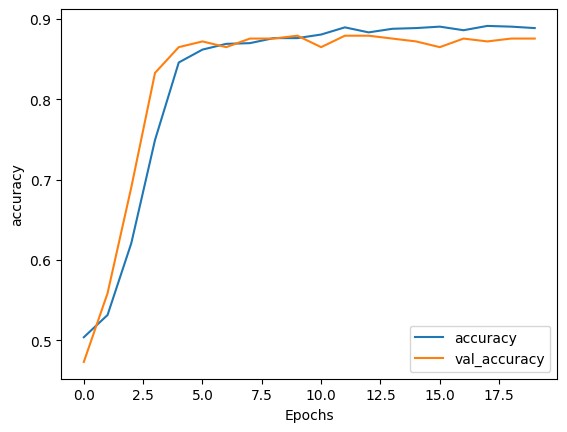

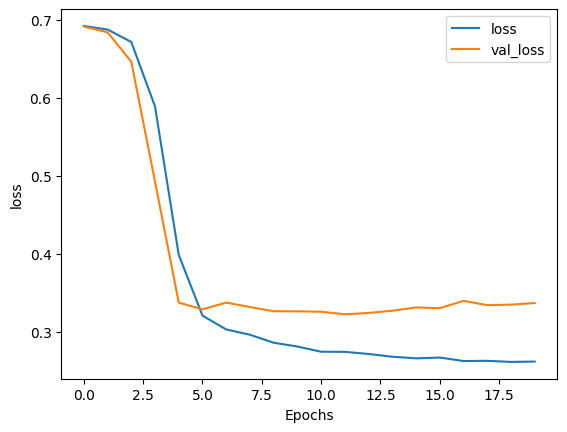

9/9 [==============================] - 2s 18ms/step
              precision    recall  f1-score   support

           0       0.83      0.92      0.87       128
           1       0.93      0.84      0.88       153

    accuracy                           0.88       281
   macro avg       0.88      0.88      0.88       281
weighted avg       0.88      0.88      0.88       281

Epoch 1/20
36/36 [==============================] - 17s 194ms/step - loss: 0.6929 - accuracy: 0.5183 - val_loss: 0.6924 - val_accuracy: 0.5231
Epoch 2/20
36/36 [==============================] - 3s 79ms/step - loss: 0.6878 - accuracy: 0.6244 - val_loss: 0.6740 - val_accuracy: 0.7580
Epoch 3/20
36/36 [==============================] - 3s 74ms/step - loss: 0.6369 - accuracy: 0.7583 - val_loss: 0.5179 - val_accuracy: 0.8185
Epoch 4/20
36/36 [==============================] - 3s 73ms/step - loss: 0.4297 - accuracy: 0.8314 - val_loss: 0.3534 - val_accuracy: 0.8612
Epoch 5/20
36/36 [==============================] - 4s 

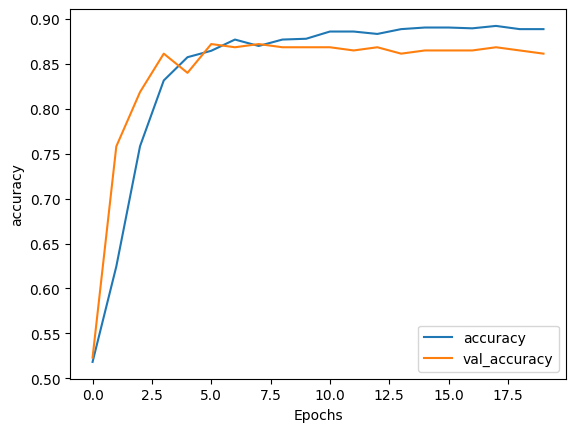

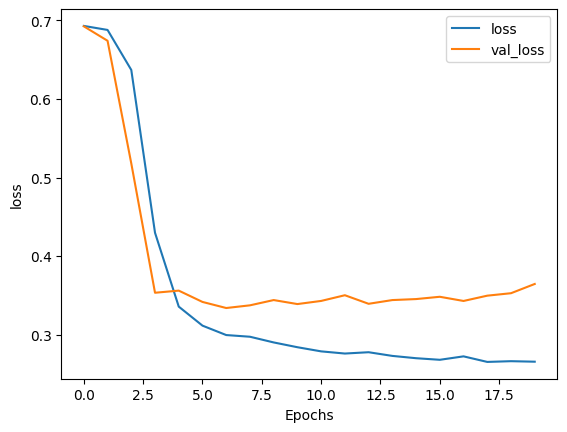

9/9 [==============================] - 2s 19ms/step
              precision    recall  f1-score   support

           0       0.80      0.93      0.86       128
           1       0.93      0.80      0.86       153

    accuracy                           0.86       281
   macro avg       0.87      0.87      0.86       281
weighted avg       0.87      0.86      0.86       281

Epoch 1/30
36/36 [==============================] - 4s 39ms/step - loss: 0.6929 - accuracy: 0.5379 - val_loss: 0.6926 - val_accuracy: 0.5089
Epoch 2/30
36/36 [==============================] - 1s 23ms/step - loss: 0.6920 - accuracy: 0.5825 - val_loss: 0.6905 - val_accuracy: 0.6335
Epoch 3/30
36/36 [==============================] - 1s 27ms/step - loss: 0.6895 - accuracy: 0.6690 - val_loss: 0.6849 - val_accuracy: 0.7580
Epoch 4/30
36/36 [==============================] - 1s 35ms/step - loss: 0.6831 - accuracy: 0.6574 - val_loss: 0.6718 - val_accuracy: 0.7936
Epoch 5/30
36/36 [==============================] - 1s 36

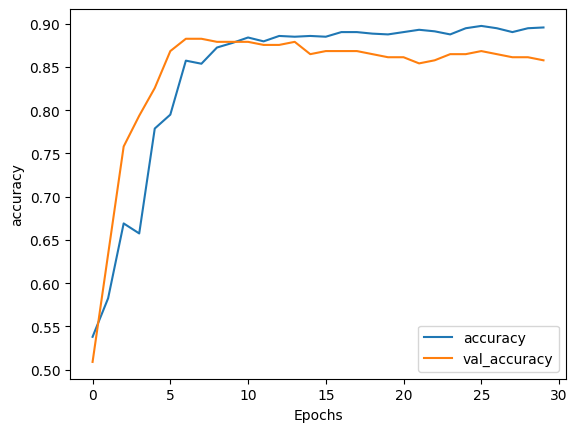

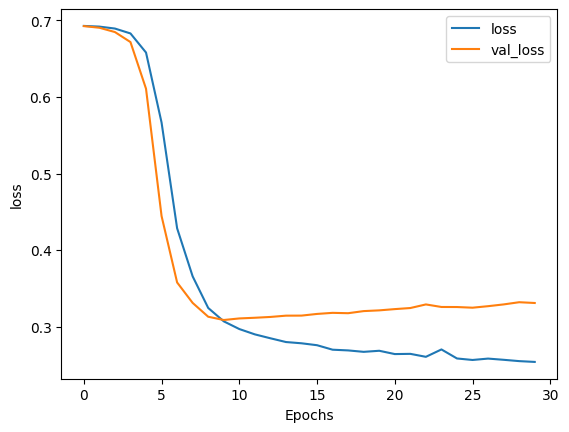

9/9 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.81      0.91      0.85       128
           1       0.91      0.82      0.86       153

    accuracy                           0.86       281
   macro avg       0.86      0.86      0.86       281
weighted avg       0.86      0.86      0.86       281

Epoch 1/30
36/36 [==============================] - 12s 122ms/step - loss: 0.6909 - accuracy: 0.5219 - val_loss: 0.6888 - val_accuracy: 0.5053
Epoch 2/30
36/36 [==============================] - 2s 58ms/step - loss: 0.6811 - accuracy: 0.6021 - val_loss: 0.6721 - val_accuracy: 0.5516
Epoch 3/30
36/36 [==============================] - 2s 58ms/step - loss: 0.6454 - accuracy: 0.6423 - val_loss: 0.6013 - val_accuracy: 0.7687
Epoch 4/30
36/36 [==============================] - 3s 89ms/step - loss: 0.5290 - accuracy: 0.8109 - val_loss: 0.4583 - val_accuracy: 0.8612
Epoch 5/30
36/36 [==============================] - 3s 7

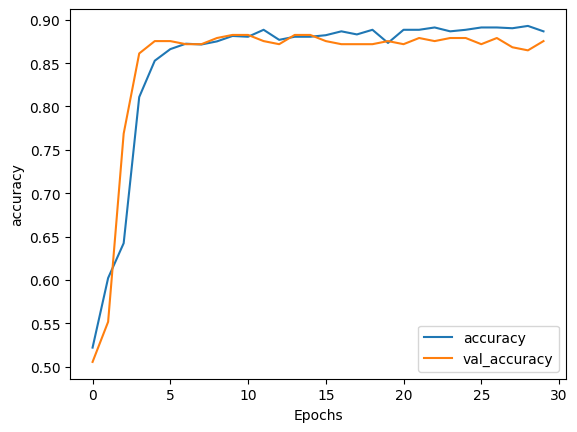

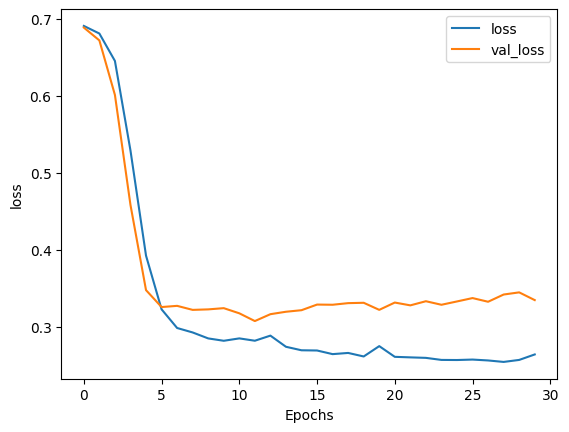

9/9 [==============================] - 1s 17ms/step
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       128
           1       0.91      0.86      0.88       153

    accuracy                           0.88       281
   macro avg       0.87      0.88      0.88       281
weighted avg       0.88      0.88      0.88       281

Epoch 1/30
36/36 [==============================] - 17s 140ms/step - loss: 0.6931 - accuracy: 0.5040 - val_loss: 0.6931 - val_accuracy: 0.4555
Epoch 2/30
36/36 [==============================] - 3s 79ms/step - loss: 0.6927 - accuracy: 0.5112 - val_loss: 0.6924 - val_accuracy: 0.4555
Epoch 3/30
36/36 [==============================] - 4s 111ms/step - loss: 0.6874 - accuracy: 0.5566 - val_loss: 0.6740 - val_accuracy: 0.5872
Epoch 4/30
36/36 [==============================] - 3s 89ms/step - loss: 0.6059 - accuracy: 0.7110 - val_loss: 0.4413 - val_accuracy: 0.8078
Epoch 5/30
36/36 [==============================] - 3s

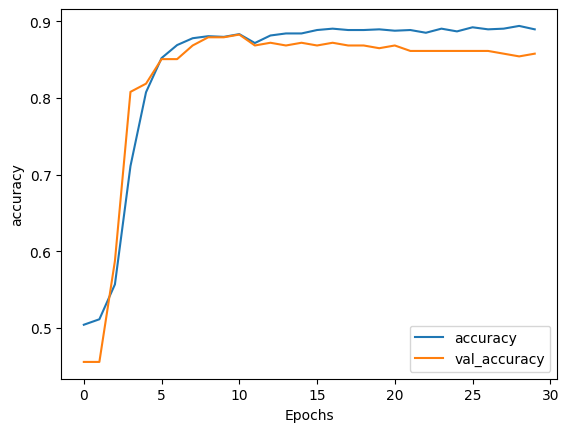

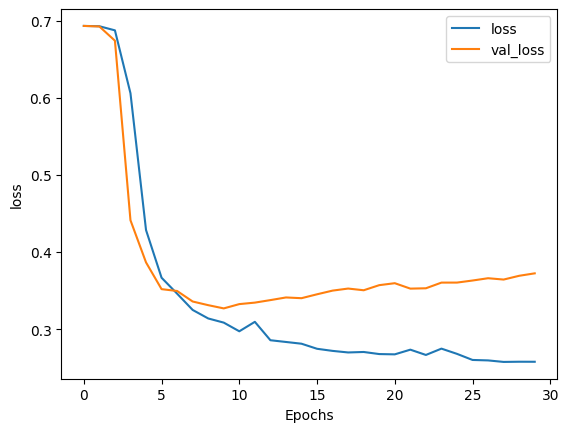

9/9 [==============================] - 3s 27ms/step
              precision    recall  f1-score   support

           0       0.79      0.93      0.86       128
           1       0.93      0.80      0.86       153

    accuracy                           0.86       281
   macro avg       0.86      0.86      0.86       281
weighted avg       0.87      0.86      0.86       281



In [40]:
arr_batch = [32]
arr_epochs = [10,20,30]
algo_layers = [1,3,5]
output = {}
idx = 0
for batch in arr_batch:
    for epoch in arr_epochs:
        for layer in algo_layers:
            model = get_model(layer)
            history = run_model(model, batch, epoch)
            ev = model.evaluate(X_test, y_test)
            
            plot_graphs(history, "accuracy")
            plot_graphs(history, "loss")

            y_pred=model.predict(X_test) 
            y_pred=np.argmax(y_pred, axis=1)
            formated_y_test=np.argmax(y_test, axis=1)
            cm = classification_report(formated_y_test, y_pred)
            print(cm)
            
            output[idx] = {'batch':batch, 'epoch':epoch, 'num_of_layer':layer, 'acc':ev, 'cm':cm}
            idx = idx+1;

In [ ]:
output

{0: {'batch': 32,
  'epoch': 10,
  'num_of_layer': 1,
  'acc': [0.3968700170516968, 0.8177278637886047],
  'cm': '              precision    recall  f1-score   support\n\n           0       0.79      0.88      0.83       412\n           1       0.85      0.75      0.80       389\n\n    accuracy                           0.82       801\n   macro avg       0.82      0.82      0.82       801\nweighted avg       0.82      0.82      0.82       801\n'},
 1: {'batch': 32,
  'epoch': 10,
  'num_of_layer': 3,
  'acc': [0.3989642858505249, 0.8252184987068176],
  'cm': '              precision    recall  f1-score   support\n\n           0       0.81      0.87      0.84       412\n           1       0.85      0.78      0.81       389\n\n    accuracy                           0.83       801\n   macro avg       0.83      0.82      0.82       801\nweighted avg       0.83      0.83      0.82       801\n'},
 2: {'batch': 32,
  'epoch': 10,
  'num_of_layer': 5,
  'acc': [0.40576720237731934, 0.832709133

In [ ]:
import json
json_object = json.dumps(output, indent = 4)
with open('lstm_dense.json', 'a') as fp:
    fp.write(json_object)